# DBScan Feature Extraction for PEX Pipe

In [ ]:
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
from sklearn.cluster import DBSCAN
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

## Functions

In [5]:
def IR_PCA(input_data, PCs):
    
    pca_model = PCA(n_components = PCs)
    data_PCs = pca_model.fit_transform(input_data)
    
    columns_list = ['PC'+ str(x) for x in range(1, PCs+1)]
    PC_df = pd.DataFrame(data = data_PCs, columns = columns_list)
    
    feature_weights = pca_model.components_
    loadings_df = pd.DataFrame(feature_weights)
    
    #result = pca.fit_transform(input_data) # Assume X is having more than 2 dimensions    
    
    print('Explained variation per principal component: {}'.format(pca_model.explained_variance_ratio_))
    
    return(PC_df, loadings_df, pca_model)

def IR_DBSCAN(input_data, eps, min_samples):
    # Apply DBSCAN
    db = DBSCAN(eps, min_samples).fit(input_data)
    labels = db.labels_

    return(db, labels)


## Manage the Dataset

(-1.0, 5.361564644644645)

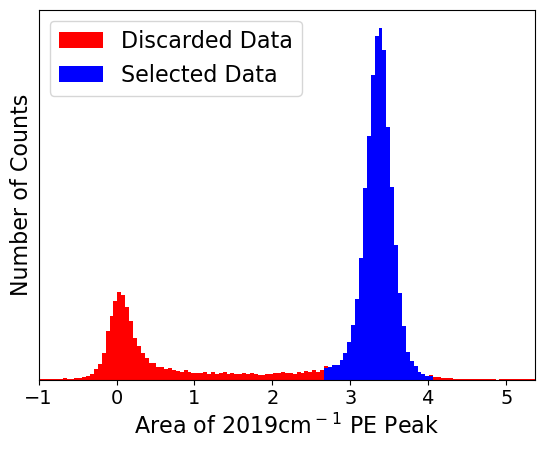

In [6]:
path ='../data/'
filename = path + 'SMP65#013 28d 920um'
filename += '.csv'

df = pd.read_csv(filename)
# Obtain the last Index before starting wavenumbers, this may change depending on data
last_nonwavenum_idx = df.columns.get_loc('1981.7 - 2095.8') + 1
# Create an array of strings containing the wavenumbers
wavenumbers = df.columns[last_nonwavenum_idx:].astype(str)

df['1981.7 - 2095.8'] = df['1981.7 - 2095.8'].astype(float)

#creating variable for the array of Polyethylene Area
areaPE = df['1981.7 - 2095.8'].values

# Use Gaussian KDE to find the center position of the rightmost mode by creating x coords
# and then using np.argmax to determine the point with the highest number of counts
kde = gaussian_kde(areaPE)
xs = np.linspace(areaPE.min(), areaPE.max(), 1000) 
modePosition = xs[np.argmax(kde(xs))]

# Use only the values greater than 1.5 to determine the std of the PE peaks
positive_vals = areaPE[areaPE > 1.5]
sigma = positive_vals.std()


# Create the upper and lower distribution bounds for the amount of data to be kept
# Two or three standard deviations has shown to be good. 
numberOfSigmas = 2

lowerDistributionBound = modePosition - numberOfSigmas * sigma
upperDistributionBound = modePosition + numberOfSigmas * sigma

# Select the range of PE normalization integral to be accepted by the mask
mask_selected = (areaPE >= lowerDistributionBound) & (areaPE <= upperDistributionBound)
selected_indexes = df.index[mask_selected]
discarded_indexes = df.index[~mask_selected]

bin_width = 0.05
bins = np.arange(min(areaPE), max(areaPE) + bin_width, bin_width)

plt.hist(areaPE,bins=bins, color='r')
plt.hist(areaPE[mask_selected], bins=bins, color='b')
plt.yticks([])
plt.xticks(fontsize=14)
plt.ylabel('Number of Counts', fontsize=16)
plt.xlabel(f'Area of 2019cm$^-$$^1$ PE Peak', fontsize=16)
plt.legend(['Discarded Data', 'Selected Data'], fontsize=16, loc='upper left')
plt.xlim([-1, modePosition + 2])

# Perform the PCA Analysis

Explained variation per principal component: [0.9538172  0.02214378]
Raw Dataset shape:  (49152, 505) Filtered Dataset shape:  (36139, 505)


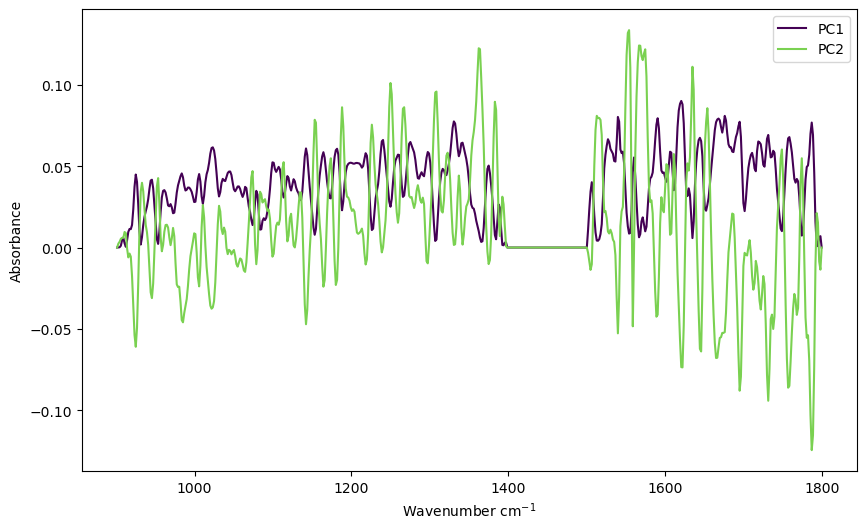

In [7]:
PCs = 2
# Create dataset containing ONLY the wavenumbers
PC_inputData = df[wavenumbers].copy()
# Modify created dataset to contain ONLY the masked values
PC_inputData = PC_inputData[mask_selected].values
# Train a PCA model on these values
PCA_df_init, loadings_df_init, pca_model = IR_PCA(PC_inputData, PCs=PCs)

print("Raw Dataset shape: ", df[wavenumbers].shape, "Filtered Dataset shape: ",PC_inputData.shape)

# Save the model to a pickle file
with open('pca_model.pkl', 'wb') as f:
    pickle.dump(pca_model, f)
# Open the same model
with open('pca_model.pkl', 'rb') as f:
    loaded_pca_model = pickle.load(f)

# Use the model again to get the same result
data_PCs = loaded_pca_model.transform(PC_inputData)
columns_list = ['PC'+ str(x) for x in range(1, PCs+1)]
PCA_df = pd.DataFrame(data = data_PCs, columns = columns_list)

PCA_df['map_x'] = df['map_x'].copy()
PCA_df['map_y'] = df['map_y'].copy()
#PCA_df['Sample Name'] = df['Sample Name']

cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 0.8, PCs))

plt.figure(figsize=(10,6))
plt.xlabel('Wavenumber cm$^{-1}$')
plt.ylabel('Absorbance')
for i in range(PCs):
    plt.plot(
        wavenumbers.astype(float),
        loadings_df_init.iloc[i, :].values,
        color=colors[i],
        label=f"PC{i+1}"
    )
plt.legend(['PC1', 'PC2'])
#plt.xlim(wavenumbers[0], wavenumbers[-1])
plt.savefig("PC1_loading_spectrum.jpeg", dpi=800)

# Plotting the PCA Analysis

Preparing data for plottings

In [8]:
PC1 = PCA_df['PC1'].to_numpy()
PC2 = PCA_df['PC2'].to_numpy()

#Reposition the mapping to start at 0,0 
Map_x = df['map_x'].to_numpy()
Map_y = df['map_y'].to_numpy()
Map_y2 = []
Map_x2 = []
Min_x = min(Map_x)
Min_y = min(Map_y)

Map_x2 = Map_x - Min_x
Map_y2 = Map_y - Min_y

x_adjusted=(np.unique(Map_x2)).tolist()
y_adjusted=(np.unique(Map_y2)).tolist()

X,Y = np.meshgrid(x_adjusted, y_adjusted)

Xsize, Ysize = len(x_adjusted), len(y_adjusted)
print("Length of X, Y: ", Xsize, Ysize, "\n")

print("Length of X*Y: ",len(x_adjusted)*len(y_adjusted), "\n")


print("Lenght of PC1: ", len(PC1), "Legnth of PC2: ", len(PC2), "\n")

target_size = len(x_adjusted) * len(y_adjusted)  

# Format PC1 for plotting
PC1_fixed = np.pad(PC1, (0, target_size - len(PC1)))

PC1 = PC1_fixed.reshape(len(x_adjusted), len(y_adjusted))

PC1 = np.reshape(PC1.copy(), (len(y_adjusted),len(x_adjusted)))

# Format PC2 for plotting

PC2_fixed = np.pad(PC2, (0, target_size - len(PC2)))

PC2 = PC2_fixed.reshape(len(x_adjusted), len(y_adjusted))

PC2 = np.reshape(PC2.copy(), (len(y_adjusted), len(x_adjusted)))

# Setting up the mask for plotting
PC1_masked =  np.ma.array(PC1, mask=~mask_selected)
PC2_masked =  np.ma.array(PC2, mask=~mask_selected)


Length of X, Y:  384 128 

Length of X*Y:  49152 

Lenght of PC1:  36139 Legnth of PC2:  36139 



Creating Figures and Plotting the PCs

In [9]:
# Prepare colormap
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 0.8, len(loadings_df)))
cmap.set_bad(color='0.7')  # dull grey for masked values

"""
Plotting the first Principal Component
"""

fig1, ax1 = plt.subplots(figsize=(8, 6))

im1 = ax1.pcolormesh(X, Y, PC1_masked, cmap='bwr', shading='auto')

cbar = fig1.colorbar(im1, ax=ax1)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'PC1', fontsize=14)

ax1.set_aspect('equal')

"""
Plotting the second Principal Component 
"""

fig2, ax2 = plt.subplots(figsize=(8, 6))

im2 = ax2.pcolormesh(X, Y, PC2_masked, cmap='bwr', shading='auto')

cbar = fig2.colorbar(im2, ax=ax2)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'PC2', fontsize=14)

ax2.set_aspect('equal')

#ax2.set_xticks([])
#ax2.set_yticks([])


NameError: name 'loadings_df' is not defined